In [104]:
from standardInclude import *

### Read in the calculated gain constants 

In [105]:
#biasVoltageString = "plusPoint2"
#biasVoltageString = "minusPoint2"
#biasVoltageString = "plusPoint1"
#biasVoltageString = "minusPoint1"
#biasVoltageString = "originalEnd"
biasVoltageString = "original"
fin = "./filterWheel_GainCalibration/biasVoltageGains_"+biasVoltageString+".txt"

In [106]:
calo = 0
xtal = -1
gainConstants = []
with open(fin) as input_file:
    for i, line in enumerate(input_file):
        #print(line)
        if("calo" in line):
            calo = int(line.split('calo')[1].split(' ')[0])
        if("xtal" in line):
            xtal = int(line.split(" ")[4].split("xtal")[1])
            constant = float(line.split(" ")[6].split("\n")[0])
            gainConstants.append([calo, xtal, constant])

### Read in the current gain settings

In [107]:
iteration = 6
filePath = "./outputGainSettings/iteration"+str(iteration)+"/"
settingsByCalo = []

for calo in range(1,25):
    settingsi = [-1 for i in range(54)]
    fin2 = filePath+"gainSettings_Iteration"+str(iteration)+"_calo"+str(calo)+".json"
    with open(fin2) as input_file:
        for i, line in enumerate(input_file):
            #print(line)
            if("calo" in line):
                #print(line)
                calo = int(line.split("calo")[1].split('"')[0])
            if("sipm" in line):
                #print(line)
                sipm = int(line.split('"')[1].split("sipm")[1])
                #print(sipm)
                #print(line.split(" "))
                setting = int(line.split(" ")[1].split(",")[0])
                settingsi[sipm] = setting
                for constants in gainConstants:
                    if((constants[0] == calo) and (constants[1] == sipm)):
                        constants.append(setting)

In [108]:
print(gainConstants[:10],"...")

[[1, 0, 0.278, 63], [1, 1, 0.295, 71], [1, 2, 0.271, 56], [1, 3, 0.297, 67], [1, 4, 0.289, 65], [1, 5, 0.274, 60], [1, 6, 0.271, 63], [1, 7, 0.269, 43], [1, 8, 0.301, 66], [1, 9, 0.234, 80]] ...


In [109]:
def si( ri ):
    #return 1.3 - 80*r.TMath.Log10( ri )
    return 104 - 80*r.TMath.Log10( ri )
    #return 80*math.log(10*10**(0.3)/ri)/2.30259   

def ri( sold ):
    return 10**( (1/20.)*(26 - sold/4.) )

def calculateSetting( constant, currentSetting ):
    goalSetting = 0.28
    
    #rs = 10**((1/20.)*(26 - currentSetting/4.))
    rs = ri(currentSetting)
    
    #s = 1.3 - 80*r.TMath.Log10(ri)
    #s = currentSetting
    #snew = s*(constant/goalSetting * ri)
    snew = si( constant/goalSetting * rs )
    
    if(False):
        print("Current setting:", currentSetting)
        print("Constant:", constant)
        print("r(s) = ", rs)
        print("New setting", snew)
        print(" ")
    
    return snew

In [110]:
calcConstants = []
for constants in gainConstants:
    calcConstants.append( calculateSetting(constants[2], constants[3]) )

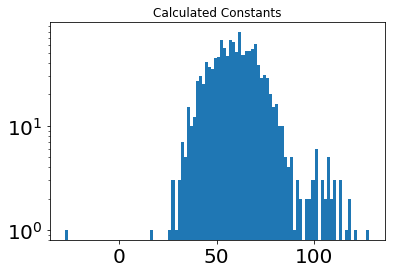

In [111]:
plt.hist(calcConstants,bins=100)
plt.yscale("log")
plt.title("Calculated Constants")
plt.show()

In [112]:
calos, xtals, initialConstants, initialSettings = zip(*gainConstants)

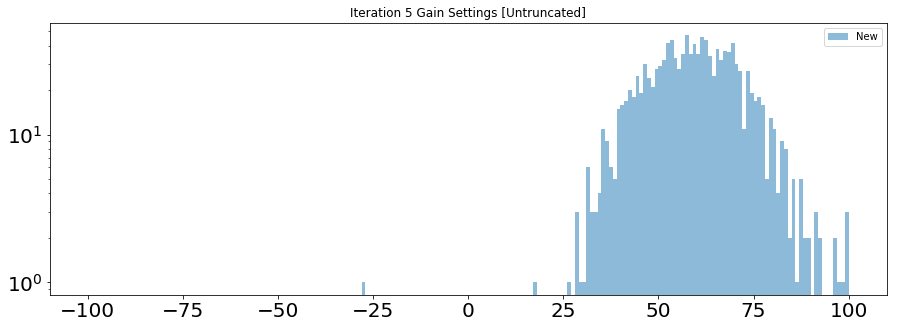

In [113]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(calcConstants,bins=200,alpha=0.5,label="New", range=(-100,100))
#plt.hist(initialSettings,bins=200,alpha=0.5,label="Old", range=(-100,100))
plt.yscale("log")
plt.title("Iteration 5 Gain Settings [Untruncated]")
plt.legend()
plt.show()

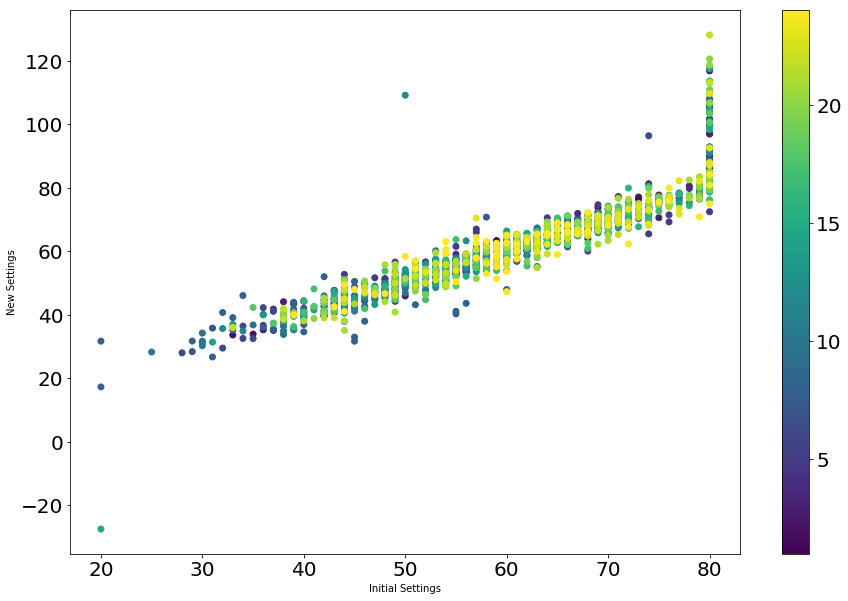

In [114]:
fig,ax = plt.subplots(figsize=(15,10))
plt.scatter(initialSettings, calcConstants, c=calos)
plt.colorbar()
plt.xlabel("Initial Settings")
plt.ylabel("New Settings")
plt.show()

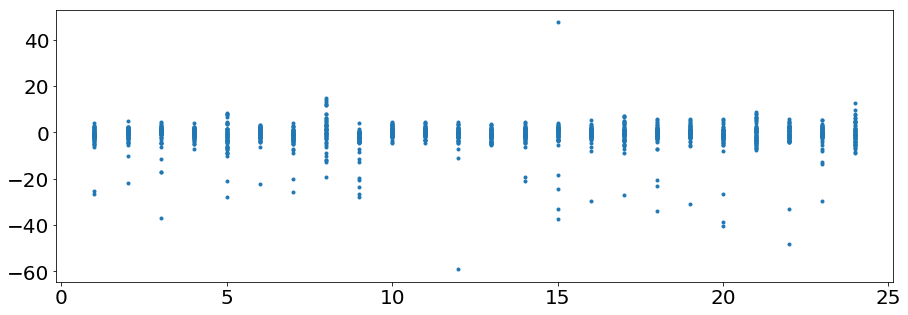

In [115]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(calos, [x-y for x,y in zip(initialSettings, calcConstants)], ".")

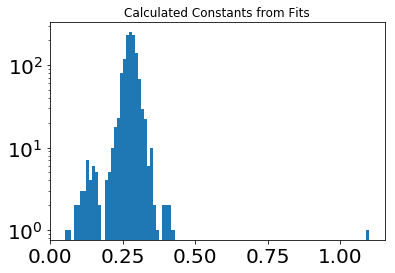

In [116]:
plt.hist(initialConstants,bins=100)
plt.yscale("log")
plt.title("Calculated Constants from Fits")
plt.show()

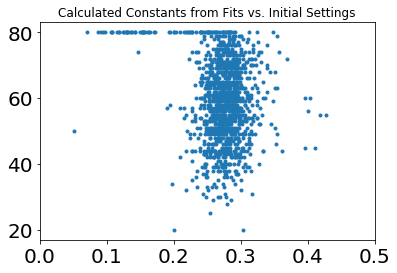

In [117]:
plt.plot(initialConstants, initialSettings, ".")
plt.title("Calculated Constants from Fits vs. Initial Settings")
plt.xlim(0,0.5)
plt.show()

In [118]:
settingsToApply = []
for gain in calcConstants:
    settingsToApply.append( gain )

In [119]:
#biasVoltageString = "original"
filePath = "./outputGainSettings/biasVoltageScans/"+biasVoltageString+"/"
for i, gainSetting in enumerate(settingsToApply):
#for i, gainSetting in enumerate(calcConstants):
    calo = int(np.floor((i) / 54) + 1)
    fileName="gainSettings_"+biasVoltageString+"_calo"+str(calo)+".json"
    #print(fileName)
    sipm = i % 54
    if(sipm == 0):
        outfile = open(filePath+fileName,"w") 
        #print("{")
        outfile.write("{"+"\n")
    #print("   \"sipm"+str(sipm)+"\": "+str(gainSetting))
    #outfile.write("   \"sipm"+str(sipm)+"\": "+str(gainSetting)+",\n")
    endchar=",\n"
    if(sipm == 53):
           endchar="\n" 
    outfile.write("\t\"sipm"+str(sipm)+"\": "+str(gainSetting)+endchar)
    if(sipm == 53):
        #print("}")
        outfile.write("}")
        outfile.close()

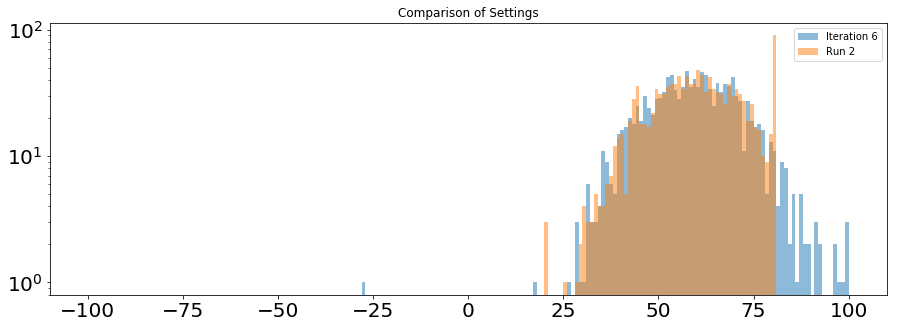

In [120]:
fig,ax = plt.subplots(figsize=(15,5))
plt.hist(settingsToApply,bins=200,alpha=0.5,label="Iteration "+str(iteration), range=(-100,100))
plt.hist(initialSettings,bins=200,alpha=0.5,label="Run 2", range=(-100,100))
plt.yscale("log")
plt.title("Comparison of Settings")
plt.legend()
plt.show()